In [2]:
import torch 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
from torch.func import vmap, grad
from tqdm import tqdm
from torch.distributions import MultivariateNormal
import h5py
from score_models import ScoreModel, NCSNpp
import json

plt.style.use("dark_background")
sys.path.append("..\\")
device = "cuda" if torch.cuda.is_available() else "cpu"

#scratch/diffusion-radio-astronomy/notebooks/real_posterior.ipynb


In [29]:
# Importing the models hparams and weights
file = open("/home/noedia/projects/rrg-lplevass/data/score_models/ncsnpp_probes_g_64_230604024652/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

torch.manual_seed(2)
score_model = ScoreModel(checkpoints_directory="/home/noedia/projects/rrg-lplevass/data/score_models/ncsnpp_probes_g_64_230604024652")
x = score_model.sample(1, shape = (1, 64, 64), steps = 500)[0,0]
img_size = img.shape[-1]

100%|██████████| 500/500 [00:11<00:00, 42.32it/s]


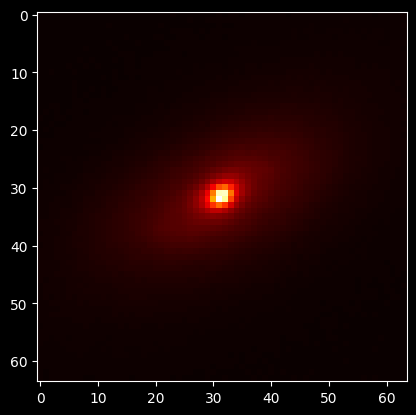

In [30]:
plt.imshow(x.cpu(), cmap = "hot")

### Creating a psf for 64 * 64 images: 

In [31]:
def resize(x, target_size=64):
    x_size = x.shape[-1] 
    start = int((x_size-target_size)/2)
    end = start + target_size
    x = x[start:end, start:end]
    return x

In [32]:
img_size = img.shape[-1]
# Path to your .fits file
fits_file_path = '../../psf_256.fits'

# Open the .fits file using Astropy
with fits.open(fits_file_path) as hdul:
    # Get the header and data from the primary HDU (Extension 0)
    header = hdul[0].header
    psf = torch.tensor((hdul[0].data).astype(np.float32))[0,0, ...].to(device)

psf = resize(psf, target_size = 64)

In [ ]:
def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")

vis_full = ft(x).flatten()
sampling_function= ft(torch.fft.ifftshift(psf)).flatten()
vis_sampled = sampling_function * vis_full

sigma_likelihood = 1e-1
vis_sampled = vis_sampled.flatten()
vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])

y_dim = len(vis_sampled)  
dist_likelihood = MultivariateNormal(loc = torch.zeros(y_dim).to(device), covariance_matrix=sigma_likelihood **2 * torch.eye(y_dim).to(device))
eta = dist_likelihood.sample([])

y = vis_sampled + eta 

In [ ]:




# PLOTS##################
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
dirty_image_noise = ift((y[:img_size**2] + 1j * y[img_size**2:]).reshape(img_size, img_size)).real


axs[0].imshow(x.reshape(img_size, img_size).cpu(), cmap = "hot")
axs[0].set_title("Ground-truth")
axs[1].imshow(dirty_image_noise.cpu(), cmap = "hot")
axs[1].set_title("Dirty image with noise")


In [25]:

def beta(t): 
    return 0.1 + (20-0.1) * t
def int_beta(t): 
    return 0.1 * t + (20 - 0.1) * t **2 / 2
 
def sigma(t): 
    return torch.sqrt(1-torch.exp(-int_beta(t)))

def logprob_likelihood(x, cov_mat): 
    dist = torch.distributions.MultivariateNormal(loc = torch.zeros(y_dim, device = y.device), covariance_matrix = cov_mat, validate_args=False)
    return dist.log_prob(x)

def f(x): 
    vis_full = ft(x.reshape(img_size, img_size)).flatten()
    vis_sampled = sampling_function * vis_full

    vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])
    return vis_sampled

def score_likelihood(x, t): 
    return vmap(grad(lambda x, t: logprob_likelihood(y- f(x),  (sigma_likelihood ** 2 + sigma(t)**2) * torch.eye(y_dim, device = x.device))))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    return score_model.score(t, x.reshape(-1, 1, img_size, img_size)).flatten(start_dim = 1) + score_likelihood(x, t)

x = torch.randn([10, img_size ** 2]).to(device) 
t = torch.ones(size = [10, 1]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_likelihood(x, t))
#logprob_likelihood(y-f2(x), sigma_likelihood**2 * torch.eye(y_dim, device = x.device)).shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.50 GiB (GPU 0; 4.00 GiB total capacity; 952.89 MiB already allocated; 1.14 GiB free; 996.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF